# OUMAZIZ Thiziri


# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [252]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [253]:
def Gradient(I):
    """ Array -> Array """
    Sx = np.array([[1,0,-1],[2, 0, -2],[1, 0, -1]]) #filtre de Sobel
    Sy = Sx.T
    Gx = convolve2d(I, Sx, boundary='symm')
    Gy = convolve2d(I, Sy, boundary='symm')

    return Gx, Gy


def computeR(I, scale, kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ix,Iy = Gradient(I) #calcul des dérivées directionnelles

    Ix2 = Ix**2
    Iy2 = Iy**2
    IxIy = Ix*Iy

    sigma = (1/3) * (int(0.5*(scale-1))) #calcul du sigma à partir du scale 
    w = gaussianKernel(sigma)
    
    w_Ix2 = convolve2d(Ix2, w, mode='same')
    w_Iy2 = convolve2d(Iy2, w, mode='same')
    w_IxIy = convolve2d(IxIy, w, mode="same")
    
    M = np.array([[w_Ix2, w_IxIy], [w_IxIy, w_Iy2]]) #construction de M
    det = M[0,0]*M[1,1] - M[0,1]*M[1,0]
    
    R = det - kappa * np.trace(M)**2
    
    return R   


2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

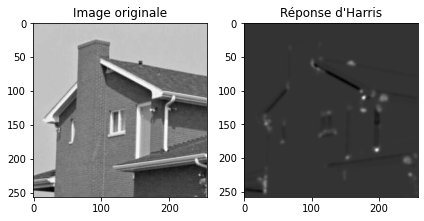

In [254]:
house2 = np.array(Image.open('img/house2.png'))
R_house2 = computeR(house2, 15, 0.04)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(house2)
plt.title("Image originale")
plt.subplot(1,2,2)
plt.imshow(R_house2)
plt.title("Réponse d'Harris")
plt.tight_layout()
plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Nous avons :

$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$

$\operatorname{det}(M) = \lambda_1 \times \lambda_2$ et $\operatorname{trace}(M) = \lambda_1 + \lambda_2$

* Les valeurs propres de la matrice M, notées $\lambda_1$ et $\lambda_2$, mesurent la variation d'intensité locale dans deux directions orthogonales.


* Dans les coins : la variation d'intensité est forte dans toutes les directions. Par conséquent, les valeurs propres $\lambda_1$ et $\lambda_2$ sont toutes deux importantes et proches l'une de l'autre. Ainsi, la valeur de $R$ est élevée. 


* Dans les contours : la variation d'intensité est forte principalement dans une seule direction (valeur propre associée élevée), tandis qu'elle est faible dans l'autre direction (valeur propre associée faible). Ainsi, la valur de $R$ est négative. 

* Dans les zones homogènes de l'image : la variation d'intensité est faible dans toutes les directions. Les deux valeurs propres, $\lambda_1$ et $\lambda_2$, sont également faibles, ce qui entraîne une valeur de $R$ faible.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [255]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    R_b = R.copy()
    R_b[R_b < thres] = 0
    R_b[R_b >= thres] = 1
    
    return R_b    

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [256]:
def ImagePadding(M,p): #fonction pour faire le padding par copie
   
    I = M.copy()
         
    for i in range(p):
        L1 = I[0, :]  
        L2 = I[-1, :] 
        I = np.vstack((L1, I, L2))

        C1 = I[:, 0]  
        C2 = I[:, -1]  
        I = np.hstack((C1[:, np.newaxis], I, C2[:, np.newaxis]))
       
    return I  

def rnms(R, R_bin):
    """ Array[n, m] -> Array[n, m] 
    """
    
    R_padded = ImagePadding(R, 1)
    R_locmax = np.zeros_like(R)
    
    for i in range(1, R.shape[0]+1):
        for j in range(1, R.shape[1]+1):
            Il = R_padded[i-1:i+2, j-1:j+2]
                      
            if R_padded[i,j] == np.max(Il) and R_bin[i-1,j-1] == 1: 
                R_locmax[i-1,j-1] = 1
                
    return R_locmax


3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [257]:
def cornerDetector(image, scale, kappa, thresh):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    R = rnms(R, thresholdR(R, thresh*R.max()))
    return R

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

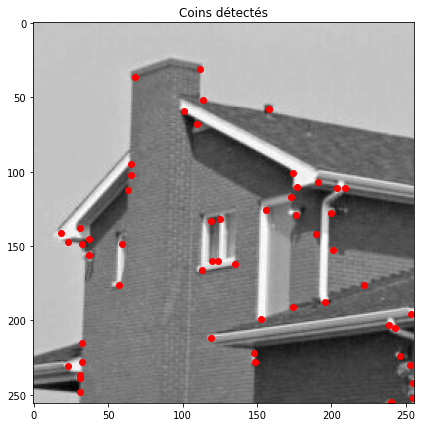

In [258]:
def display_corners(I, scale, kappa, thresh, title):
    C = cornerDetector(I, scale, kappa, thresh)
    plt.figure(figsize=(7,7))
    plt.imshow(I)
    plt.scatter(*np.nonzero(C.T), c='red')
    plt.title(title)
    plt.show()

display_corners(house2, 15 , 0.04, 0.01, "Coins détectés")

Nous pouvons voir que le détecteur arrive tout de même à bien identifier plusieurs coins.

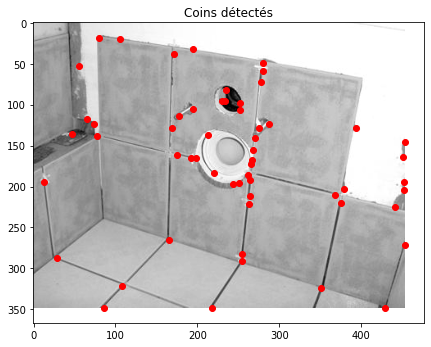

In [259]:
carrelage = np.array(Image.open("img/carrelage_wikipedia.jpg"))
display_corners(carrelage, 15 , 0.04, 0.03, "Coins détectés")

Image assez complexe comportant plusieurs irrégularités pouvant être interprétées comme des coins.

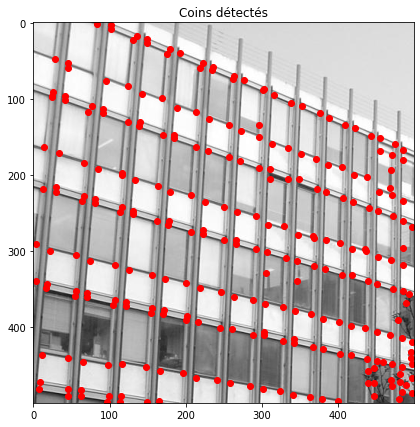

In [224]:
Jussieu = np.array(Image.open("img/Jussieu_wikipedia.jpg"))
display_corners(Jussieu, 15 , 0.04, 0.05, "Coins détectés")

Les coins sont assez bien détectés surtout ceux des fenêtres, nous pouvons jouer sur le seuil et le scale pour en ignorer certains. 

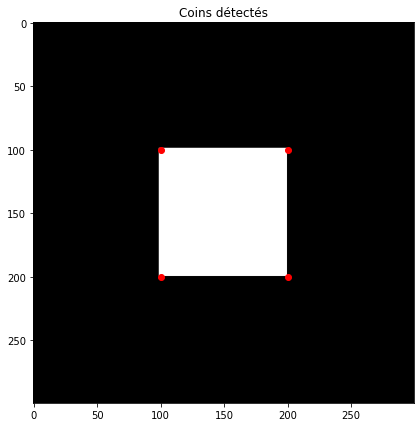

In [214]:
Rectangle = np.array(Image.open("img/rectangle.png"))
display_corners(Rectangle, 5 , 0.04, 0.01, "Coins détectés")

Ici, les coins sont détectés mais le petit décalage est dû au lissage avec le filtre gaussien (j'ai pris W plus petit pour réduire le décalage). Le lissage fait perdre en précision spatiale. 

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

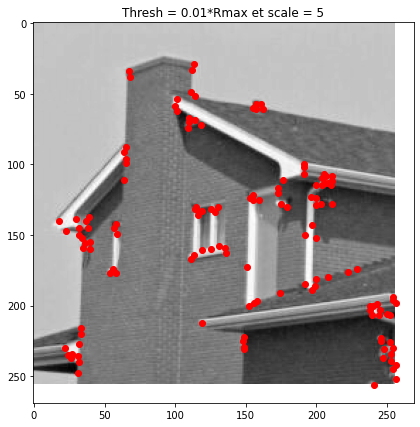

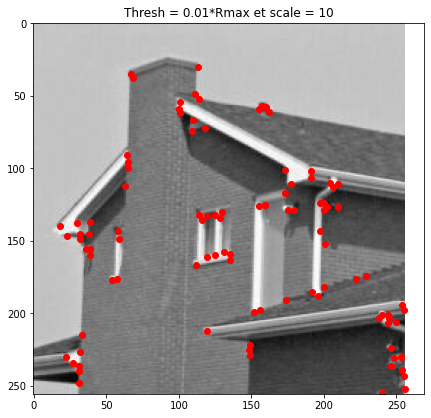

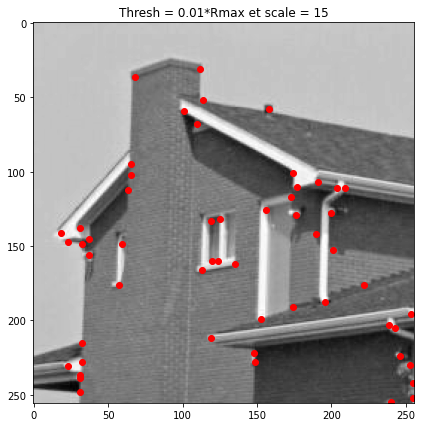

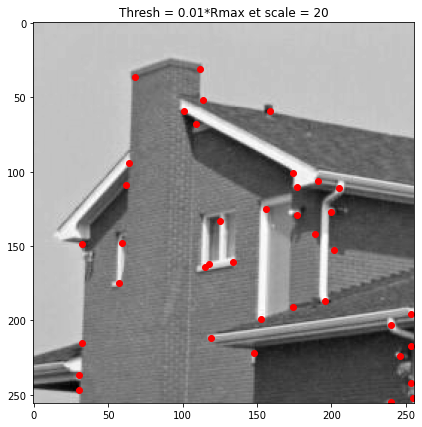

In [215]:
scales = [5, 10, 15, 20]

for i in range(4):
    display_corners(house, scales[i] , 0.04, 0.01, f"Thresh = 0.01*Rmax et scale = {scales[i]}")
    plt.show()

L'application du filtre gaussien permet de réduire le bruit en lissant l'image, et dans une certaine mesure, cela facilite la détection des coins. Cependant, plus le lissage est intense, plus nous perdons en précision spatiale.

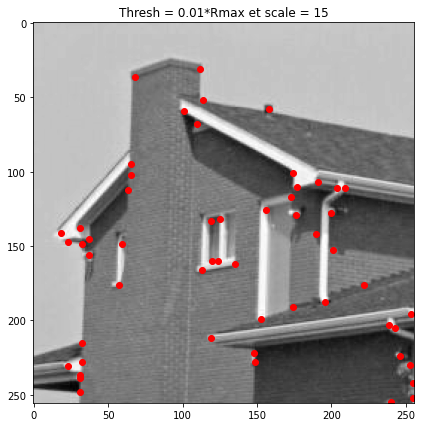

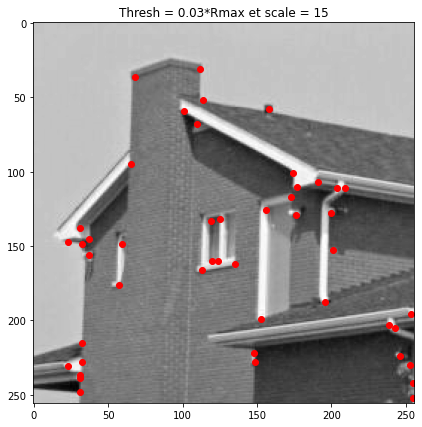

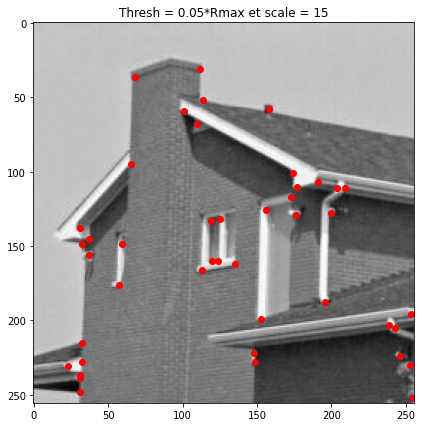

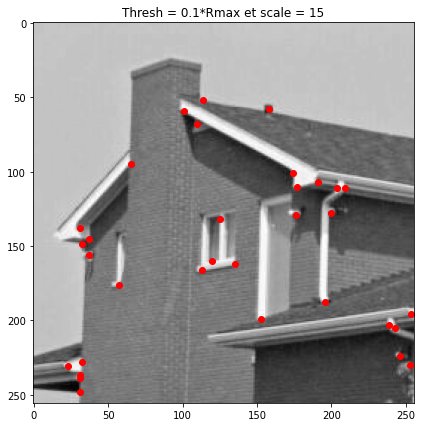

In [226]:
thresholds = [0.01, 0.03, 0.05, 0.1]

for i in range(4):
    display_corners(house, 15 , 0.04, thresholds[i], f"Thresh = {thresholds[i]}*Rmax et scale = 15")
    plt.show()

En augmentant la valeur du seuil, nous éliminons certains faux positifs, mais pour une valeur trop élevée, des coins peuvent ne pas être détectés.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

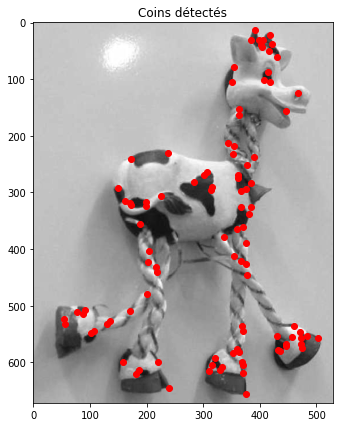

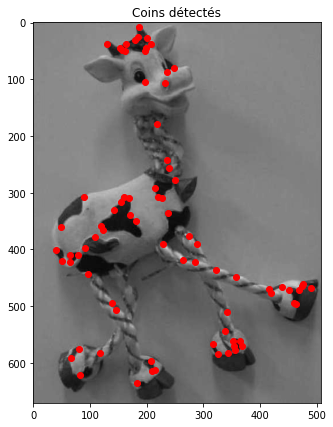

In [234]:
toyHorse1 = np.array(Image.open("img/toyHorse1.png"))
toyHorse2 = np.array(Image.open("img/toyHorse2.png"))
display_corners(toyHorse1, 15, 0.04, 0.05, "Coins détectés")
display_corners(toyHorse2, 15, 0.04, 0.05, "Coins détectés")


2) What are the dynamic ranges of these two images ?

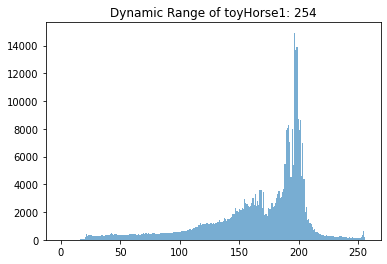

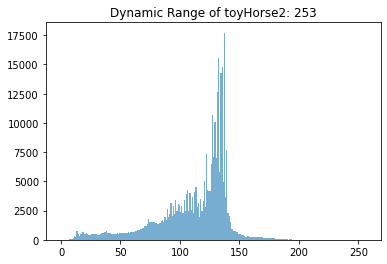

In [241]:
def calculate_dynamic_range(I):
    return np.max(I) - np.min(I) 

def plot_histogram(I, title):
    plt.hist(I.ravel(), bins=256, range=(0, 256), alpha=0.6)
    plt.title(title)
    plt.show()
    
 
dynamic_range1 = calculate_dynamic_range(toyHorse1)
dynamic_range2 = calculate_dynamic_range(toyHorse2)

plot_histogram(toyHorse1, f"Dynamic Range of toyHorse1: {dynamic_range1}")
plot_histogram(toyHorse2, f"Dynamic Range of toyHorse2: {dynamic_range2}")    


Les plages de valeurs des pixels des deux images sont similaires. Cependant, il est évident, d'après l'histogramme, que la première image est plus lumineuse.   

3) What are the transformations beetween the two images ?

Nous pouvons voir qu'il y a eu une rotation donc un angle de vue différent et que la luminosité des deux images est différente. 

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

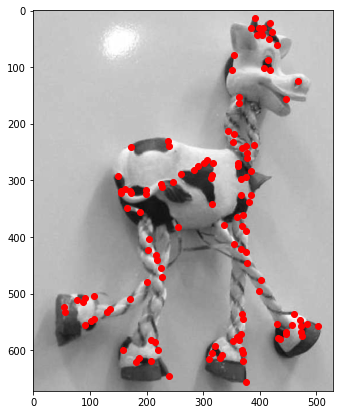

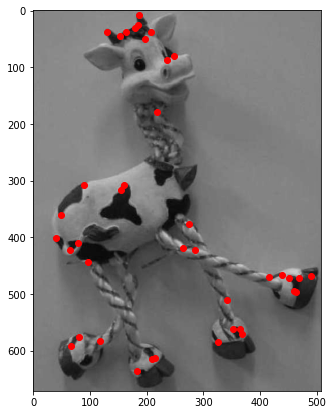

In [251]:
R1 = computeR(toyHorse1, 15, 0.04)
R2 = computeR(toyHorse2, 15, 0.04)
thresh_f = 0.05*((R1.max() + R2.max())/2)

def display_corner_fixed_thresh(image, scale, kappa, thresh):
    
    R = computeR(image, scale, kappa)
    R = rnms(R, thresholdR(R, thresh))
    
    plt.figure(figsize=(7,7))
    plt.imshow(image)
    plt.scatter(*np.nonzero(R.T), c='red')
    plt.show()
    
display_corner_fixed_thresh(toyHorse1, 15 , 0.04, thresh_f)
display_corner_fixed_thresh(toyHorse2, 15 , 0.04, thresh_f)    

* Dans le cas de la question 1, avec l'utilisation d'un seuil dynamique, nous pouvons identifier des similitudes dans la détection de coins des deux images malgré la rotation et le changement de luminosité. 
* Pour un seuil fixe, nous pouvons observer que la détection des coins varie en fonction des changements d'angle de vue et de luminosité. Ainsi, le détecteur d'Harris est sensible au seuil choisi. 